<a href="https://colab.research.google.com/github/surajsrivathsa/ovgu_deeplearning/blob/master/nmt_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Assignment 5:** Attention-based Neural Machine Translation

**Team members:**
1. Sanjeeth Busnur Indushekar: 224133 : sanjeeth.busnur@st.ovgu.de
2. Suraj Shashidhar: 230052 : suraj.shashidhar@st.ovgu.de
3. Himanshi Bajaj: 225827  : himanshi.bajaj@st.ovgu.de

**Tasks to be done**

- Use English-German Language as it is mostly known.
- Train the Attention based NMT for Bahadanau model and store it.
- Train the Attention based NMT for Luong model and store it.
- Train the Attention based NMT for dot product model and store it.
- Compare attention weights(qualitative differences) of three different mechanism for chosen two examples.

Bahadanu Attention: 
- Is the model attending to correct tokens in the sequence between three attention mechanisms.


**Questions and Answers**

1. Which parts of the sentence are used as a token? Each character, each word, or are some words split up?

**Word level tokenization, but doesn't consider apostrophes in words. Like "can't"/"don't" will be considerd as don + t or can + t two separate tokens.**

2. Do the same tokens in different language have the same ID?
e.g. Would the same token index map to the German word die and to the English word die?

**We are calling tokenize methods separately for two languages, this results in different ID being assigned to each token. But there may be a chance that same tokens like "die" in english and "die" in german may be allocated same ID.**

3. What is the relation between the encoder output and the encoder hidden state which is used to initialize the decoder hidden state?
(for the architecture used in the tutorial)

**Encoder output depends on encoder hidden state which contains some sort of lossy summary of other states. This will be used in conjunction with encoder input to calculate current output.**

4. Is the decoder attending to all previous positions, including the previous decoder predictions?

**Decoder has access to all encoder positions and last decoder position.**


5. Does the Encoder output change in different decoding steps?

**Encoder output will not change, but what decoder sees from it changes according to attention(like wearing different lenses on same object).**

6. Does the context vector change in different decoding steps?

**Context vector changes according to query of decoder as it can focus on required positions.**

7. The decoder uses teacher forcing. Does this mean the time steps can be computed in parallel?

**If Deocder was not using Hidden states for computation, then we could have parallelized the prediction process, But decoder hidden states depends on previous decoder hidden states and are not available in parallel. Hence for this program we cannot parallelize it.**

# Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)


8. Why is a mask applied to the loss function?

**This is somewhat similar to 6th assignment of deep learning. Without masking we will be calculating the loss for padded sequence position, This is wrong as they are not real characters but artificial and introduced by us.**

# **Comparision of attention mechanism**

1. **Do you see qualitative differences in the attention weights between different attention mechanisms?**

**Bahadanu attention**
- As we can see, Bahadanu attention seems to be hit/miss on correct translations as it did not translate second sentence.

- In first sentence can't is correctly focussing on Kann Nicht
- Second sentence about flowers gave wrong translations.

**Luong attention**
- The translations for 1,3 sentences were correct but 2nd sentence was wrong.
- From attention weights it is evident that the focus was on wrong things.

**Dot Product Attention**
- The translations for 1,3 sentences were correct but 2nd sentence was wrong.
- From attention weights it is evident that the focus was on wrong things.

2. **Do you think that the model attends to the correct tokens in the input language? (if you understand both languages)**

- No for Dot product and Luong it seems like it was not attending to proper tokens.

# Preprocessing and tokenization

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path_to_file = "/content/drive/My Drive/Colab Notebooks"+"/deu-eng/deu.txt"

In [8]:

def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
  w = w.strip()
  w = '<start> ' + w + ' <end>'
  return w

In [7]:
en_sentence = u"This can't be happening."
ge_sentence = u"Das kann nicht passieren."
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(ge_sentence).encode('utf-8'))

<start> this can t be happening . <end>
b'<start> das kann nicht passieren . <end>'


In [46]:
en_sentence = u"The flower die at night."
ge_sentence = u"Die Blume stirbt nachts"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(ge_sentence).encode('utf-8'))

<start> the flower die at night . <end>
b'<start> die blume stirbt nachts <end>'


**As we can see the tokens are split at word level, but can't, don't etcwords that have apostrophes are not translated to cannot/do not and split. hence there seems to be extra token left**

In [9]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, GERMAN]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [10]:
en, ge, _ = create_dataset(path_to_file , None)
print(en[3])
print(ge[3])

<start> doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> ohne zweifel findet sich auf dieser welt zu jedem mann genau die richtige ehefrau und umgekehrt wenn man jedoch in betracht zieht , dass ein mensch nur gelegenheit hat , mit ein paar hundert anderen bekannt zu sein , von denen ihm nur ein dutzend oder weniger nahesteht , darunter hochstens ein oder zwei freunde , dann erahnt man eingedenk der millionen einwohner dieser welt leicht , dass seit erschaffung ebenderselben wohl noch 

In [12]:
print(len(en))
print(len(ge))
print(en[3])
print(ge[3])

221533
221533
<start> run ! <end>
<start> lauf ! <end>


In [13]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
  return tensor, lang_tokenizer

In [14]:
def load_dataset(path, num_examples=None):
  targ_lang, inp_lang , _= create_dataset(path, num_examples)
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

Number of examples to be used for training. More the examples more is the training time and resources, but better is the translation quality.

Find the max length of tensors this can be used in padding

In [15]:
num_examples = 60000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [102]:
print(max_length_inp)
print(max_length_targ)

22
11


**One can see the padding of "0" and also the difference between english and german. The length of sentences need not be the same.**

In [21]:
print(input_tensor[9],target_tensor[9])

[   1   20 6530   13    2    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0] [ 1 72 50  2  0  0  0  0  0  0  0]


In [47]:
print(input_tensor[650],target_tensor[650])

[   1 1179   10   13    2    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0] [  1  27  11 259   3   2   0   0   0   0   0]


In [23]:
# Creating training and validation sets using an 90-10 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.1)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

54000 54000 6000 6000


In [24]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [25]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
245 ----> ware
8 ----> das
4 ----> tom
7 ----> ?
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
180 ----> would
15 ----> that
38 ----> be
4 ----> tom
7 ----> ?
2 ----> <end>


In [26]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [27]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 22]), TensorShape([64, 11]))

In [28]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [29]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 22, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


# Bahadanu Attention mechanism and Decoder

**Bahadanu Attention taken from google NMT Notebook**

In [30]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [31]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 22, 1)


In [32]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [33]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 6701)


# Luong attention mechanism and decoder

In [161]:
class LuongAttention(tf.keras.layers.Layer):
  def __init__(self,units, max_len_inp):
    super(LuongAttention,self).__init__()
    self.W_a = tf.keras.layers.Dense(units)
    self.L = tf.keras.layers.Dense(max_len_inp)
  
  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)
    #print("query with time axis shape: {}".format(query_with_time_axis.shape))
    #print("values shape: {}".format(values.shape))
    #print("inner dot product shape: {}".format(tf.multiply(values,query_with_time_axis).shape))
    #print("dot product sum shape: {}".format(tf.reduce_sum( tf.multiply(values,query_with_time_axis), 2).shape))

    new_tnsr = tf.matmul(self.W_a(query_with_time_axis), values, transpose_b=True)   
    product_score = tf.transpose(new_tnsr, [0, 2, 1])
    
    #print("luong mat mul new attention shape before.: {}".format(new_tnsr.shape))
    #print("luong mat mul new attention shape after.: {}".format(product_score.shape))

    #product_score = self.L(tf.reduce_sum( tf.multiply(values,query_with_time_axis), 2))
    #print("product score shape before: {}".format(product_score.shape))
    
    #product_score = tf.expand_dims(product_score,2)
    #print("product score shape after: {}".format(product_score.shape))
    attention_weights = tf.nn.softmax(product_score,axis = 1)
    #print("attention weights shape: {}".format(attention_weights.shape))
    context = attention_weights*values
    #print("context weight before: {}".format(context.shape))
    context = tf.reduce_sum(context, axis=1)
    #print("context weight after: {}".format(context.shape))
    return context, attention_weights

In [153]:
luong_attention_layer = LuongAttention(1024, 22)
print("sample hidden shape: {}".format(sample_hidden.shape))
print("sample output shape: {}".format(sample_output.shape))
luongcontext,luongattention = luong_attention_layer(sample_hidden,sample_output)

print("Luong Attention result shape: (batch size, units) {}".format(luongcontext.shape))
print("Luong Attention weights shape: (batch_size, sequence_length, 1) {}".format(luongattention.shape))

sample hidden shape: (64, 1024)
sample output shape: (64, 22, 1024)
query with time axis shape: (64, 1, 1024)
values shape: (64, 22, 1024)
inner dot product shape: (64, 22, 1024)
dot product sum shape: (64, 22)
luong mat mul new attention shape before.: (64, 1, 22)
luong mat mul new attention shape after.: (64, 22, 1)
attention weights shape: (64, 22, 1)
context weight before: (64, 22, 1024)
context weight after: (64, 1024)
Luong Attention result shape: (batch size, units) (64, 1024)
Luong Attention weights shape: (batch_size, sequence_length, 1) (64, 22, 1)


In [162]:
luong_attention_layer = LuongAttention(1024, 22)
print("sample hidden shape: {}".format(sample_hidden.shape))
print("sample output shape: {}".format(sample_output.shape))
luongcontext,luongattention = luong_attention_layer(sample_hidden,sample_output)

print("Luong Attention result shape: (batch size, units) {}".format(luongcontext.shape))
print("Luong Attention weights shape: (batch_size, sequence_length, 1) {}".format(luongattention.shape))

sample hidden shape: (64, 1024)
sample output shape: (64, 22, 1024)
Luong Attention result shape: (batch size, units) (64, 1024)
Luong Attention weights shape: (batch_size, sequence_length, 1) (64, 22, 1)


In [163]:
class LuongDecoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(LuongDecoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
    #This depends on dataset, we have printed this variable out in earlier cell and got this value
    self.max_input_length = 22
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = LuongAttention(self.dec_units, self.max_input_length)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [174]:
luongdecoder = LuongDecoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

luong_sample_decoder_output, _, _ = luongdecoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Luong Decoder output shape: (batch_size, vocab size) {}'.format(luong_sample_decoder_output.shape))

Luong Decoder output shape: (batch_size, vocab size) (64, 6701)


# Dot product attention and Decoder

In [48]:
class DotProductAttention(tf.keras.layers.Layer):
  def __init__(self,units):
    super(DotProductAttention,self).__init__()
  
  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)
    dot_product_score = (tf.reduce_sum( tf.multiply(values,query_with_time_axis), 2))
    dot_product_score = tf.expand_dims(dot_product_score,2)
    dot_attention_weights = tf.nn.softmax(dot_product_score,axis = 1)
    context = dot_attention_weights*values
    context = tf.reduce_sum(context, axis=1)
    return context, dot_attention_weights

In [49]:
attention_layer = DotProductAttention(10)
context,attention = attention_layer(sample_hidden,sample_output)

print(context.shape,attention.shape)

(64, 1024) (64, 22, 1)


In [58]:
class DotproductDecoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(DotproductDecoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = DotProductAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [67]:
dotproduct_decoder = DotproductDecoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = dotproduct_decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 6701)


# Optimizers, loss function and checkpoints

## Define the optimizer and the loss function

In [34]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints for all three attention mechanism

In [35]:
checkpoint_dir = './bahadanu_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,encoder=encoder,decoder=decoder)

In [175]:
luong_checkpoint_dir = './luong_training_checkpoints'
luong_checkpoint_prefix = os.path.join(luong_checkpoint_dir, "ckpt")
luong_checkpoint = tf.train.Checkpoint(optimizer=optimizer,encoder=encoder,decoder=luongdecoder)

In [60]:
dotproduct_checkpoint_dir = './dotproduct_training_checkpoints'
dotproduct_checkpoint_prefix = os.path.join(dotproduct_checkpoint_dir, "ckpt")
dotproduct_checkpoint = tf.train.Checkpoint(optimizer=optimizer,encoder=encoder,decoder=decoder)

# Bahadanu Training

In [36]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [37]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6803
Epoch 1 Batch 100 Loss 2.2226
Epoch 1 Batch 200 Loss 1.9139
Epoch 1 Batch 300 Loss 1.8550
Epoch 1 Batch 400 Loss 1.5151
Epoch 1 Batch 500 Loss 1.5162
Epoch 1 Batch 600 Loss 1.3272
Epoch 1 Batch 700 Loss 1.3847
Epoch 1 Batch 800 Loss 1.2458
Epoch 1 Loss 1.7103
Time taken for 1 epoch 101.5291075706482 sec

Epoch 2 Batch 0 Loss 1.0822
Epoch 2 Batch 100 Loss 1.0066
Epoch 2 Batch 200 Loss 1.1500
Epoch 2 Batch 300 Loss 0.9390
Epoch 2 Batch 400 Loss 0.9020
Epoch 2 Batch 500 Loss 0.9523
Epoch 2 Batch 600 Loss 0.8083
Epoch 2 Batch 700 Loss 0.9101
Epoch 2 Batch 800 Loss 0.7276
Epoch 2 Loss 0.9169
Time taken for 1 epoch 92.74819421768188 sec

Epoch 3 Batch 0 Loss 0.6704
Epoch 3 Batch 100 Loss 0.5957
Epoch 3 Batch 200 Loss 0.6474
Epoch 3 Batch 300 Loss 0.5088
Epoch 3 Batch 400 Loss 0.5309
Epoch 3 Batch 500 Loss 0.5424
Epoch 3 Batch 600 Loss 0.4711
Epoch 3 Batch 700 Loss 0.5526
Epoch 3 Batch 800 Loss 0.4470
Epoch 3 Loss 0.5680
Time taken for 1 epoch 91.57316851615906 sec

# Luong Attention Training

In [176]:
@tf.function
def luong_train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = luongdecoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  #There is no trainable parameters in dot product attention, but decoder has some
  variables = encoder.trainable_variables + luongdecoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [177]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = luong_train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    luong_checkpoint.save(file_prefix = luong_checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.8161
Epoch 1 Batch 100 Loss 1.5287
Epoch 1 Batch 200 Loss 1.2935
Epoch 1 Batch 300 Loss 0.8767
Epoch 1 Batch 400 Loss 0.9651
Epoch 1 Batch 500 Loss 0.8474
Epoch 1 Batch 600 Loss 0.7478
Epoch 1 Batch 700 Loss 0.7989
Epoch 1 Batch 800 Loss 0.6811
Epoch 1 Loss 1.1132
Time taken for 1 epoch 83.10695600509644 sec

Epoch 2 Batch 0 Loss 0.4276
Epoch 2 Batch 100 Loss 0.5700
Epoch 2 Batch 200 Loss 0.4289
Epoch 2 Batch 300 Loss 0.4930
Epoch 2 Batch 400 Loss 0.5821
Epoch 2 Batch 500 Loss 0.4487
Epoch 2 Batch 600 Loss 0.4196
Epoch 2 Batch 700 Loss 0.4373
Epoch 2 Batch 800 Loss 0.4604
Epoch 2 Loss 0.4765
Time taken for 1 epoch 73.54482626914978 sec

Epoch 3 Batch 0 Loss 0.3564
Epoch 3 Batch 100 Loss 0.3458
Epoch 3 Batch 200 Loss 0.3842
Epoch 3 Batch 300 Loss 0.2754
Epoch 3 Batch 400 Loss 0.2395
Epoch 3 Batch 500 Loss 0.3615
Epoch 3 Batch 600 Loss 0.3246
Epoch 3 Batch 700 Loss 0.2796
Epoch 3 Batch 800 Loss 0.3028
Epoch 3 Loss 0.3111
Time taken for 1 epoch 75.07558131217957 sec

In [178]:
!zip -r "luong_training_checkpoints.zip" "/content/luong_training_checkpoints"

  adding: content/luong_training_checkpoints/ (stored 0%)
  adding: content/luong_training_checkpoints/ckpt-3.data-00000-of-00001 (deflated 15%)
  adding: content/luong_training_checkpoints/ckpt-2.index (deflated 68%)
  adding: content/luong_training_checkpoints/ckpt-5.data-00000-of-00001 (deflated 15%)
  adding: content/luong_training_checkpoints/ckpt-1.index (deflated 68%)
  adding: content/luong_training_checkpoints/checkpoint (deflated 38%)
  adding: content/luong_training_checkpoints/ckpt-1.data-00000-of-00001 (deflated 16%)
  adding: content/luong_training_checkpoints/ckpt-3.index (deflated 68%)
  adding: content/luong_training_checkpoints/ckpt-4.data-00000-of-00001 (deflated 15%)
  adding: content/luong_training_checkpoints/ckpt-4.index (deflated 68%)
  adding: content/luong_training_checkpoints/ckpt-2.data-00000-of-00001 (deflated 15%)
  adding: content/luong_training_checkpoints/ckpt-5.index (deflated 68%)


# Dot Product Training

In [69]:
@tf.function
def dotproduct_train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = dotproduct_decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  #There is no trainable parameters in dot product attention, but decoder has some
  variables = encoder.trainable_variables + dotproduct_decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [70]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = dotproduct_train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = dotproduct_checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.8742
Epoch 1 Batch 100 Loss 1.9220
Epoch 1 Batch 200 Loss 1.5580
Epoch 1 Batch 300 Loss 1.4169
Epoch 1 Batch 400 Loss 1.1690
Epoch 1 Batch 500 Loss 1.1467
Epoch 1 Batch 600 Loss 0.8516
Epoch 1 Batch 700 Loss 0.9973
Epoch 1 Batch 800 Loss 0.8158
Epoch 1 Loss 1.3453
Time taken for 1 epoch 81.01361179351807 sec

Epoch 2 Batch 0 Loss 0.7765
Epoch 2 Batch 100 Loss 0.6597
Epoch 2 Batch 200 Loss 0.6066
Epoch 2 Batch 300 Loss 0.5129
Epoch 2 Batch 400 Loss 0.6118
Epoch 2 Batch 500 Loss 0.5734
Epoch 2 Batch 600 Loss 0.6416
Epoch 2 Batch 700 Loss 0.5817
Epoch 2 Batch 800 Loss 0.5866
Epoch 2 Loss 0.6124
Time taken for 1 epoch 72.2137463092804 sec

Epoch 3 Batch 0 Loss 0.2598
Epoch 3 Batch 100 Loss 0.3725
Epoch 3 Batch 200 Loss 0.4173
Epoch 3 Batch 300 Loss 0.3314
Epoch 3 Batch 400 Loss 0.4056
Epoch 3 Batch 500 Loss 0.3791
Epoch 3 Batch 600 Loss 0.3675
Epoch 3 Batch 700 Loss 0.3242
Epoch 3 Batch 800 Loss 0.3651
Epoch 3 Loss 0.3667
Time taken for 1 epoch 70.81332421302795 sec


In [ ]:
!zip -r "bahadanau_training_checkpoints.zip" "/content/bahadanu_training_checkpoints"

# Restore latest check point of bahadanu attention and evaluate

**Added clim=[0,1] to the plotting function**

In [38]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [40]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis',clim=[0,1])

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [41]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [42]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> das kann nicht passieren . <end>
Predicted translation: that cannot do it . <end> 


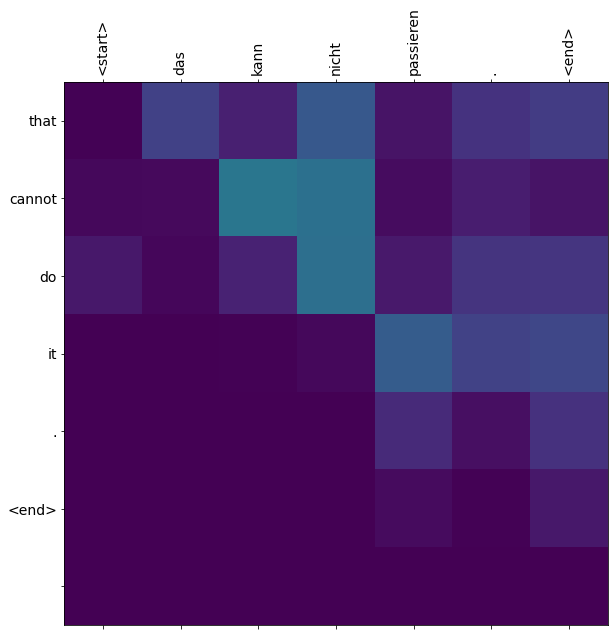

In [43]:
translate(u'Das kann nicht passieren.')

Input: <start> die blume fallt wahrend der nacht . <end>
Predicted translation: the honeymoon is over . <end> 


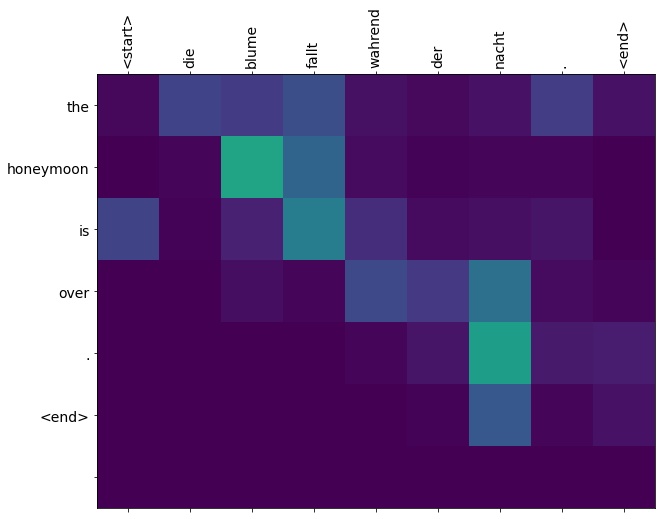

In [45]:
translate(u'Die Blume fällt während der Nacht.')

In [ ]:
!zip -r "training_checkpoints.zip" "/content/training_checkpoints"

  adding: content/training_checkpoints/ (stored 0%)
  adding: content/training_checkpoints/ckpt-5.data-00000-of-00001 (deflated 17%)
  adding: content/training_checkpoints/ckpt-5.index (deflated 70%)
  adding: content/training_checkpoints/ckpt-2.data-00000-of-00001 (deflated 17%)
  adding: content/training_checkpoints/ckpt-1.data-00000-of-00001 (deflated 17%)
  adding: content/training_checkpoints/ckpt-4.data-00000-of-00001 (deflated 17%)
  adding: content/training_checkpoints/ckpt-1.index (deflated 70%)
  adding: content/training_checkpoints/ckpt-3.index (deflated 70%)
  adding: content/training_checkpoints/ckpt-2.index (deflated 70%)
  adding: content/training_checkpoints/checkpoint (deflated 38%)
  adding: content/training_checkpoints/ckpt-3.data-00000-of-00001 (deflated 17%)
  adding: content/training_checkpoints/ckpt-4.index (deflated 70%)


In [97]:
!zip -r "bahadanau_training_checkpoints.zip" "/content/bahadanu_training_checkpoints"

  adding: content/bahadanu_training_checkpoints/ (stored 0%)
  adding: content/bahadanu_training_checkpoints/ckpt-3.data-00000-of-00001 (deflated 15%)
  adding: content/bahadanu_training_checkpoints/ckpt-2.index (deflated 69%)
  adding: content/bahadanu_training_checkpoints/ckpt-5.data-00000-of-00001 (deflated 15%)
  adding: content/bahadanu_training_checkpoints/ckpt-1.index (deflated 69%)
  adding: content/bahadanu_training_checkpoints/checkpoint (deflated 38%)
  adding: content/bahadanu_training_checkpoints/ckpt-1.data-00000-of-00001 (deflated 15%)
  adding: content/bahadanu_training_checkpoints/ckpt-3.index (deflated 69%)
  adding: content/bahadanu_training_checkpoints/ckpt-4.data-00000-of-00001 (deflated 15%)
  adding: content/bahadanu_training_checkpoints/ckpt-4.index (deflated 69%)
  adding: content/bahadanu_training_checkpoints/ckpt-2.data-00000-of-00001 (deflated 15%)
  adding: content/bahadanu_training_checkpoints/ckpt-5.index (deflated 69%)


# Restore the latest checkpoint of luong attention and evaluating

In [184]:
def luong_evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = luongdecoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [183]:
# function for plotting the attention weights
def luong_plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis',clim=[0,1])

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [182]:
def luong_translate(sentence):
  result, sentence, attention_plot = luong_evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  luong_plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [185]:
luong_checkpoint.restore(tf.train.latest_checkpoint(luong_checkpoint_dir))

Input: <start> das kann nicht passieren . <end>
Predicted translation: that can t happen . <end> 


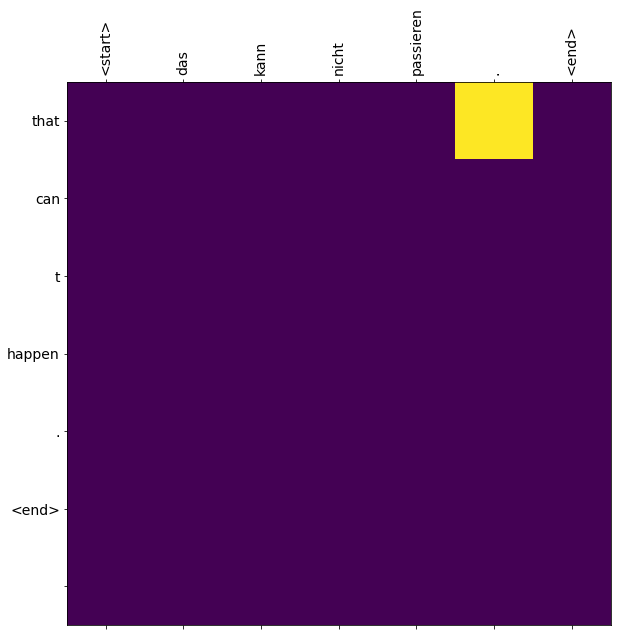

In [186]:
luong_translate(u'Das kann nicht passieren.')

Input: <start> die blume fallt wahrend der nacht . <end>
Predicted translation: the birds . <end> 


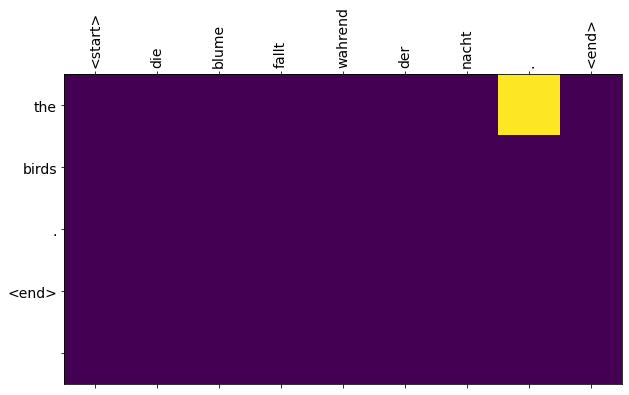

In [187]:
luong_translate(u'Die Blume fällt während der Nacht.')

Input: <start> er ist gestern gestorben . <end>
Predicted translation: he died yesterday . <end> 


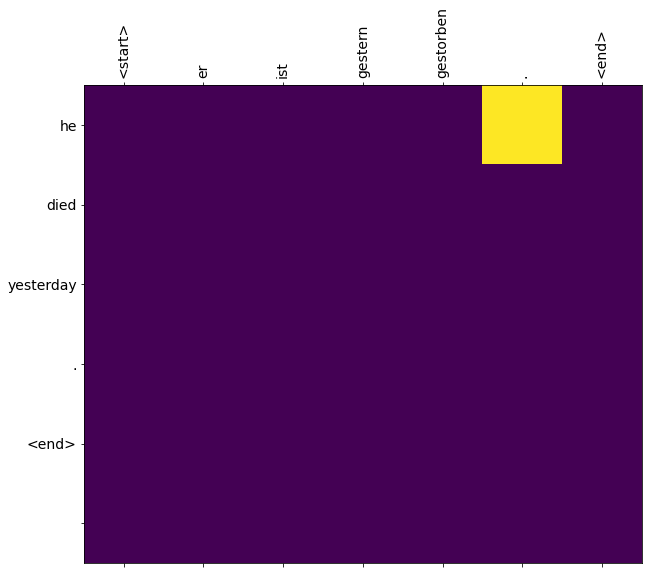

In [188]:
luong_translate(u'Er ist gestern gestorben.')

# Restore the latest checkpoint of dot product attention and evaluating

In [77]:
def dotproduct_evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = dotproduct_decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [84]:
# function for plotting the attention weights
def dotproduct_plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis',clim=[0,1])

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [93]:
def dotproduct_translate(sentence):
  result, sentence, attention_plot = dotproduct_evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  dotproduct_plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [91]:
dotproduct_checkpoint.restore(tf.train.latest_checkpoint(dotproduct_checkpoint_dir))

Input: <start> das kann nicht passieren . <end>
Predicted translation: that can t happen . <end> 


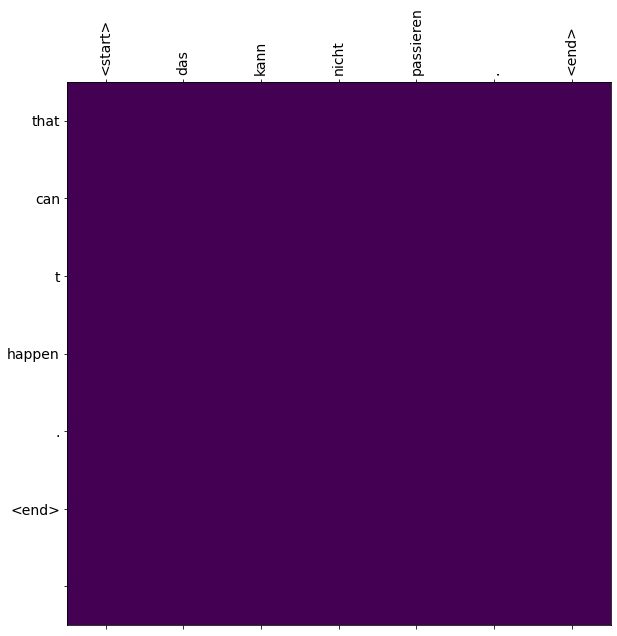

In [94]:
dotproduct_translate(u'Das kann nicht passieren.')

Input: <start> die blume fallt wahrend der nacht . <end>
Predicted translation: the theater is final night . <end> 


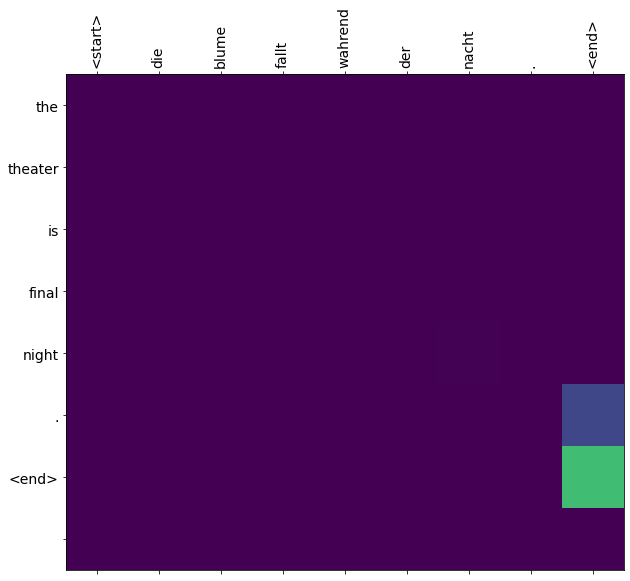

In [95]:
dotproduct_translate(u'Die Blume fällt während der Nacht.')

Input: <start> er ist gestern gestorben . <end>
Predicted translation: he died yesterday . <end> 


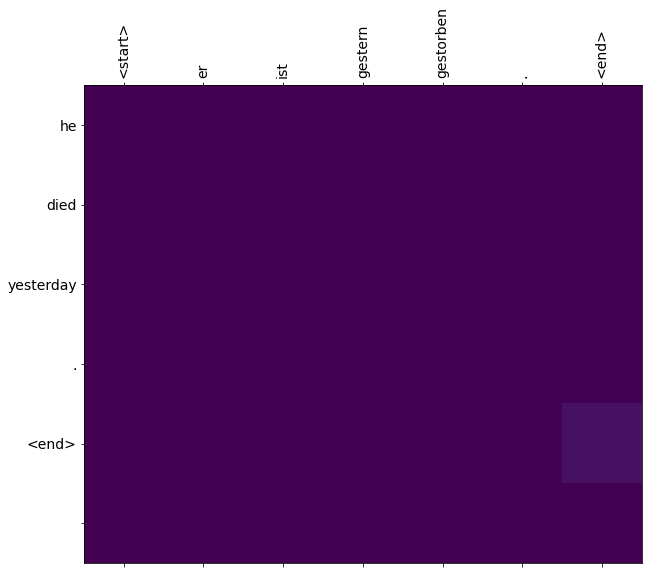

In [96]:
dotproduct_translate(u'Er ist gestern gestorben.')

In [98]:
!zip -r "dotproduct_training_checkpoints.zip" "/content/dotproduct_training_checkpoints"

  adding: content/dotproduct_training_checkpoints/ (stored 0%)
  adding: content/dotproduct_training_checkpoints/ckpt-3.data-00000-of-00001 (deflated 53%)
  adding: content/dotproduct_training_checkpoints/ckpt-2.index (deflated 71%)
  adding: content/dotproduct_training_checkpoints/ckpt-5.data-00000-of-00001 (deflated 53%)
  adding: content/dotproduct_training_checkpoints/ckpt-1.index (deflated 71%)
  adding: content/dotproduct_training_checkpoints/checkpoint (deflated 38%)
  adding: content/dotproduct_training_checkpoints/ckpt-1.data-00000-of-00001 (deflated 53%)
  adding: content/dotproduct_training_checkpoints/ckpt-3.index (deflated 71%)
  adding: content/dotproduct_training_checkpoints/ckpt-4.data-00000-of-00001 (deflated 53%)
  adding: content/dotproduct_training_checkpoints/ckpt-4.index (deflated 72%)
  adding: content/dotproduct_training_checkpoints/ckpt-2.data-00000-of-00001 (deflated 53%)
  adding: content/dotproduct_training_checkpoints/ckpt-5.index (deflated 71%)
